In [2]:
from sklearn.datasets import make_circles
# 搞1000个样本差不多吧
n_samples = 1000

#创建圆圈
X, y = make_circles(n_samples,
                    noise=0.03, #整点噪声
                    random_state=42) #经典42种子

In [6]:
print(f"前5个特征：\n{X[:5]}")
print(f"前5个标注：\n{y[:5]}")

前5个特征：
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
前5个标注：
[1 1 1 1 0]


In [7]:
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0], 
                        "X2": X[:, 1], 
                        "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


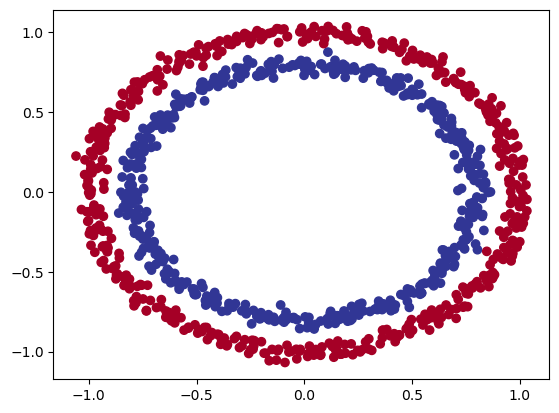

In [8]:
# Visualize with a plot
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0], 
            y=X[:, 1], 
            c=y, 
            cmap=plt.cm.RdYlBu);

In [9]:
X.shape, y.shape

((1000, 2), (1000,))

In [10]:
X_sample = X[0]
y_sample = y[0]
print(f"第一个样本 X: {X_sample}, y: {y_sample}")
print(f"X Shape: {X_sample.shape}, y Shape: {y_sample.shape}")

第一个样本 X: [0.75424625 0.23148074], y: 1
X Shape: (2,), y Shape: ()


In [11]:
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

print(X[:5], y[:5])

tensor([[ 0.7542,  0.2315],
        [-0.7562,  0.1533],
        [-0.8154,  0.1733],
        [-0.3937,  0.6929],
        [ 0.4422, -0.8967]]) tensor([1., 1., 1., 1., 0.])


In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)
print(len(X_train),len(y_train), len(X_test), len(y_test))

800 800 200 200


In [14]:
import torch
from torch import nn

# 诊断代码
device = "cuda" if torch.cuda.is_available() else "mps"
device

'mps'

In [15]:
# 1. 构建mode类
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. 创建两个线性层，分别对应输入与输出 5意味着有隐藏层的5个神经元
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)

    # 3.定义前向传播计算
    def forward(self, x):
        #返回输出层的结果
        return self.layer_2(self.layer_1(x))
    
# 4.创建模型实例并将其配置入相应设备
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [16]:
untrained_preds = model_0(X_test.to(device))
print(f"{len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"{len(y_test)}, Shape: {y_test.shape}")
print(f"前10个预测结果{untrained_preds[:10]}, {y_test[:10]}")

200, Shape: torch.Size([200, 1])
200, Shape: torch.Size([200])
前10个预测结果tensor([[0.4771],
        [0.4955],
        [0.3749],
        [0.5063],
        [0.2894],
        [0.3013],
        [0.4210],
        [0.3753],
        [0.3786],
        [0.4958]], device='mps:0', grad_fn=<SliceBackward0>), tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [17]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr = 0.1)

In [18]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [20]:
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[0.4771],
        [0.4955],
        [0.3749],
        [0.5063],
        [0.2894]], device='mps:0', grad_fn=<SliceBackward0>)

In [21]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.6171],
        [0.6214],
        [0.5926],
        [0.6239],
        [0.5718]], device='mps:0', grad_fn=<SigmoidBackward0>)

In [22]:
y_preds = torch.round(y_pred_probs)

y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

y_preds.squeeze()

tensor([True, True, True, True, True], device='mps:0')


tensor([1., 1., 1., 1., 1.], device='mps:0', grad_fn=<SqueezeBackward0>)

In [23]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [29]:
torch.manual_seed(42)
# 设置迭代100次
epochs = 100

# 将tensor放入目标设备
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# 建立评估循环
for epoch in range(epochs):
    model_0.train()

    # 1. 前向传播（模型输出logits）
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits - 预测概率 - 预测标签

    # 2. 计算loss/accuracy
    loss = loss_fn(y_logits,
                   y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)
    
    # 3. optimize zero grad
    optimizer.zero_grad()

    # 4. loss backwards
    loss.backward()

    # 5. optimize step
    optimizer.step()

    # 测试
    model_0.eval()

    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)
    
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")
    

Epoch: 0 | Loss: 0.71176, Accuracy: 50.00% | Test loss: 0.71309, Test acc: 50.00%
Epoch: 10 | Loss: 0.69935, Accuracy: 50.00% | Test loss: 0.70145, Test acc: 50.00%
Epoch: 20 | Loss: 0.69531, Accuracy: 50.00% | Test loss: 0.69757, Test acc: 50.00%
Epoch: 30 | Loss: 0.69395, Accuracy: 52.50% | Test loss: 0.69621, Test acc: 54.50%
Epoch: 40 | Loss: 0.69346, Accuracy: 54.50% | Test loss: 0.69568, Test acc: 49.00%
Epoch: 50 | Loss: 0.69326, Accuracy: 52.62% | Test loss: 0.69545, Test acc: 47.00%
Epoch: 60 | Loss: 0.69317, Accuracy: 52.38% | Test loss: 0.69533, Test acc: 46.50%
Epoch: 70 | Loss: 0.69311, Accuracy: 51.50% | Test loss: 0.69525, Test acc: 47.00%
Epoch: 80 | Loss: 0.69308, Accuracy: 51.38% | Test loss: 0.69520, Test acc: 47.00%
Epoch: 90 | Loss: 0.69306, Accuracy: 50.88% | Test loss: 0.69516, Test acc: 46.50%


In [15]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


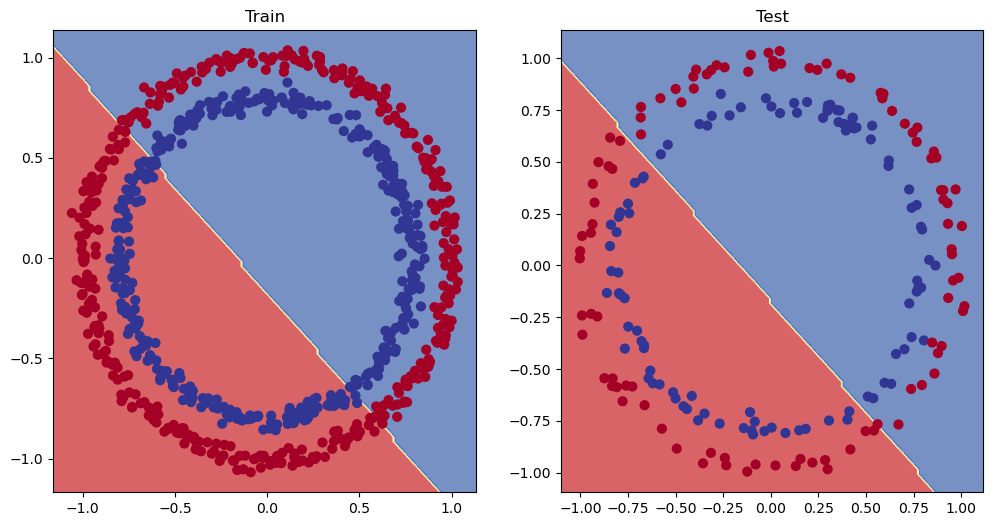

In [31]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

In [76]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10) # extra layer
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        return self.layer_3(self.layer_2(self.layer_1(x)))
    
model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [77]:
loss_fn = nn.BCEWithLogitsLoss() # 不需要sigmoid
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)
torch.manual_seed(42)
epochs = 1000 # 这次迭代1000次
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
for epoch in range(epochs):
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true = y_train, 
                      y_pred = y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    model_1.eval()
    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

        
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")



Epoch: 0 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 100 | Loss: 0.69305, Accuracy: 50.38% | Test loss: 0.69379, Test acc: 48.00%
Epoch: 200 | Loss: 0.69299, Accuracy: 51.12% | Test loss: 0.69437, Test acc: 46.00%
Epoch: 300 | Loss: 0.69298, Accuracy: 51.62% | Test loss: 0.69458, Test acc: 45.00%
Epoch: 400 | Loss: 0.69298, Accuracy: 51.12% | Test loss: 0.69465, Test acc: 46.00%
Epoch: 500 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69467, Test acc: 46.00%
Epoch: 600 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 700 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 800 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 900 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%


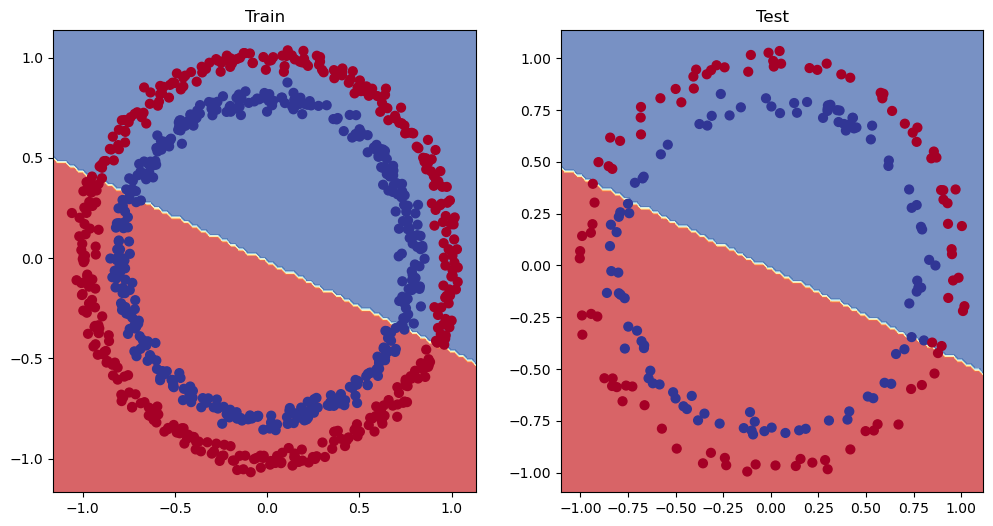

In [78]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

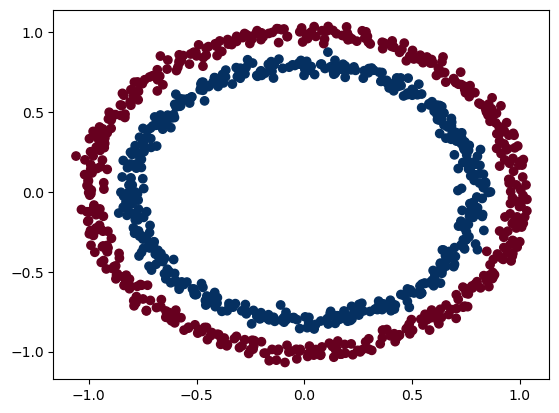

In [50]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
n_samples = 1000
X, y = make_circles(n_samples=1000,
                    noise=0.03,
                    random_state=42)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu)

In [ ]:
import torch
from sklearn.model_selection import train_test_split
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [100]:
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=20)
        self.layer_2 = nn.Linear(in_features=20, out_features=20)
        self.layer_3 = nn.Linear(in_features=20, out_features=1)
        self.relu = nn.ReLU() # 将ReLU作为激活函数

    def forward(self, x):
        # 传入ReLU
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
model_3 = CircleModelV2().to(device)
print(model_3)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=20, bias=True)
  (layer_2): Linear(in_features=20, out_features=20, bias=True)
  (layer_3): Linear(in_features=20, out_features=1, bias=True)
  (relu): ReLU()
)


In [101]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)
torch.manual_seed(42)
epochs = 10000
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
for epoch in range(epochs):
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true = y_train, 
                      y_pred = y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    model_3.eval()
    with torch.inference_mode():
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

        
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")



Epoch: 0 | Loss: 0.69448, Accuracy: 47.62% | Test loss: 0.69197, Test acc: 54.00%
Epoch: 100 | Loss: 0.69102, Accuracy: 53.12% | Test loss: 0.68961, Test acc: 56.50%
Epoch: 200 | Loss: 0.68750, Accuracy: 56.88% | Test loss: 0.68704, Test acc: 57.00%
Epoch: 300 | Loss: 0.68379, Accuracy: 59.62% | Test loss: 0.68357, Test acc: 59.50%
Epoch: 400 | Loss: 0.67821, Accuracy: 63.12% | Test loss: 0.67807, Test acc: 63.00%
Epoch: 500 | Loss: 0.66898, Accuracy: 69.50% | Test loss: 0.66913, Test acc: 72.00%
Epoch: 600 | Loss: 0.65292, Accuracy: 75.38% | Test loss: 0.65433, Test acc: 77.00%
Epoch: 700 | Loss: 0.62314, Accuracy: 85.62% | Test loss: 0.62753, Test acc: 84.00%
Epoch: 800 | Loss: 0.56538, Accuracy: 94.62% | Test loss: 0.57623, Test acc: 94.00%
Epoch: 900 | Loss: 0.45988, Accuracy: 99.38% | Test loss: 0.48168, Test acc: 98.00%
Epoch: 1000 | Loss: 0.31106, Accuracy: 99.75% | Test loss: 0.34226, Test acc: 100.00%
Epoch: 1100 | Loss: 0.62981, Accuracy: 56.62% | Test loss: 0.64925, Test acc

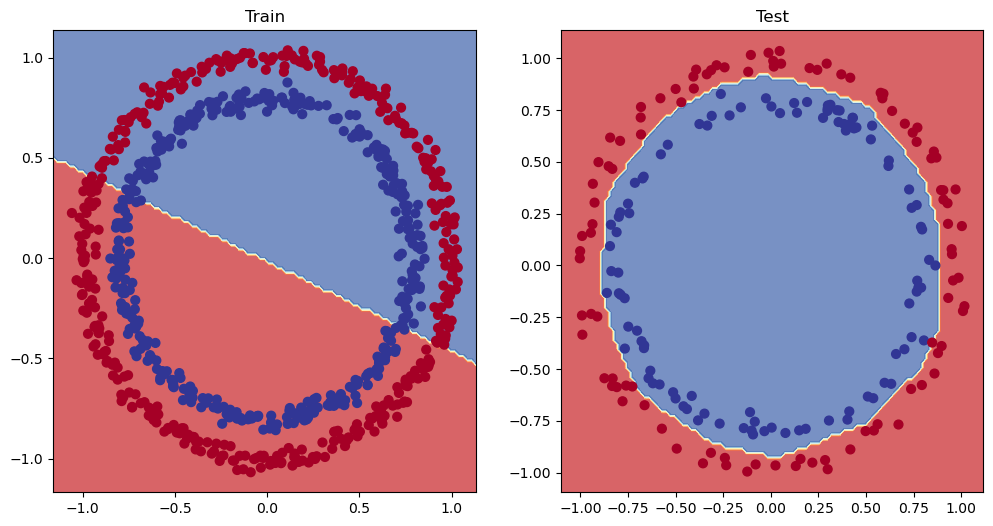

In [102]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity

In [103]:
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

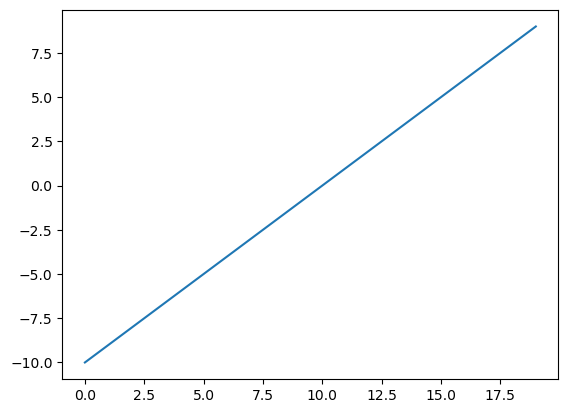

In [104]:
plt.plot(A)

In [107]:
def relu(x):
    return torch.maximum(torch.tensor(0), x)
relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

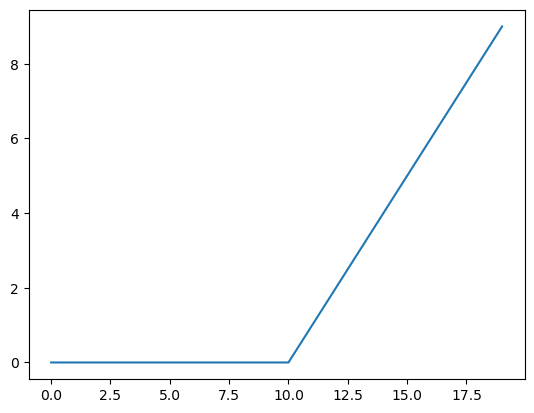

In [108]:
plt.plot(relu(A))

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


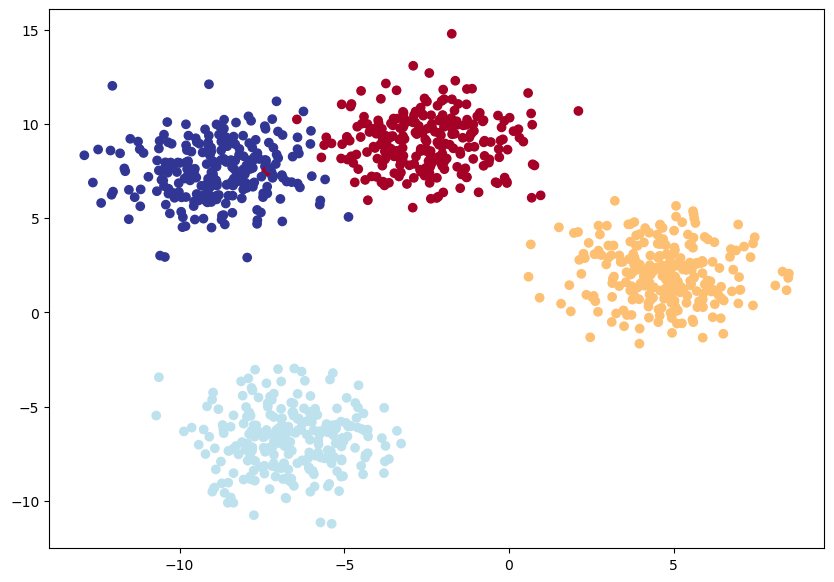

In [1]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. 创建多元数据
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)

# 2. 转换数据为Tensor
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])


# 3. 将数据分成训练与测试集
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)

# 4. 绘图
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c = y_blob, cmap=plt.cm.RdYlBu);

In [2]:
# Create device agnostic code
# device = "cuda" if torch.cuda.is_available() else "cpu"
# device

# I Use Mac Arm
device = "mps"
from torch import nn
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):

        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features,
                      out_features=hidden_units),
            nn.Linear(in_features=hidden_units,
                      out_features=hidden_units),
            nn.Linear(in_features=hidden_units,
                      out_features=output_features)
        )

    def forward(self, x):
        return self.linear_layer_stack(x)
    
model_4 = BlobModel(input_features=NUM_FEATURES,
                    output_features=NUM_CLASSES,
                    hidden_units=8).to(device)
model_4


BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [3]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), lr = 0.1)
model_4(X_blob_train.to(device))[:5]

tensor([[-0.9426, -1.1327,  1.1206,  0.9330],
        [ 0.2319,  0.7969, -0.1233, -1.0421],
        [ 1.0767,  1.8816, -2.0599, -1.4857],
        [ 0.7108,  1.3664, -1.3765, -1.1476],
        [ 0.3342,  0.9273, -0.3604, -1.0932]], device='mps:0',
       grad_fn=<SliceBackward0>)

In [6]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

torch.manual_seed(42)
epochs = 100
X_blob_train,y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test,y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    model_4.train()

    y_logits = model_4(X_blob_train)

    # 使用Softmax作为多元分类的激活函数
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)


    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)
    
    optimizer.zero_grad()
    loss.backward()

    optimizer.step()

    model_4.eval()
    with torch.inference_mode():
        test_logits = model_4(X_blob_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_true=y_blob_test,
                               y_pred=test_pred)
        
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 3.16168, Acc: 0.00% | Test Loss: 0.71833, Test Acc: 70.00%
Epoch: 10 | Loss: 0.13974, Acc: 99.12% | Test Loss: 0.12622, Test Acc: 99.50%
Epoch: 20 | Loss: 0.07961, Acc: 99.00% | Test Loss: 0.07126, Test Acc: 99.50%
Epoch: 30 | Loss: 0.05916, Acc: 99.00% | Test Loss: 0.05126, Test Acc: 99.50%
Epoch: 40 | Loss: 0.04919, Acc: 99.00% | Test Loss: 0.04119, Test Acc: 99.50%
Epoch: 50 | Loss: 0.04339, Acc: 99.12% | Test Loss: 0.03519, Test Acc: 99.50%
Epoch: 60 | Loss: 0.03963, Acc: 99.12% | Test Loss: 0.03124, Test Acc: 99.50%
Epoch: 70 | Loss: 0.03701, Acc: 99.12% | Test Loss: 0.02844, Test Acc: 99.50%
Epoch: 80 | Loss: 0.03510, Acc: 99.12% | Test Loss: 0.02637, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03365, Acc: 99.12% | Test Loss: 0.02477, Test Acc: 99.50%


In [12]:
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

y_pred_probs = torch.softmax(y_logits, dim=1)
y_preds = y_pred_probs.argmax(dim=1)
y_preds

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 0, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1], device='mps:0')

In [13]:

print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")›

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='mps:0')
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='mps:0')
Test accuracy: 99.5%


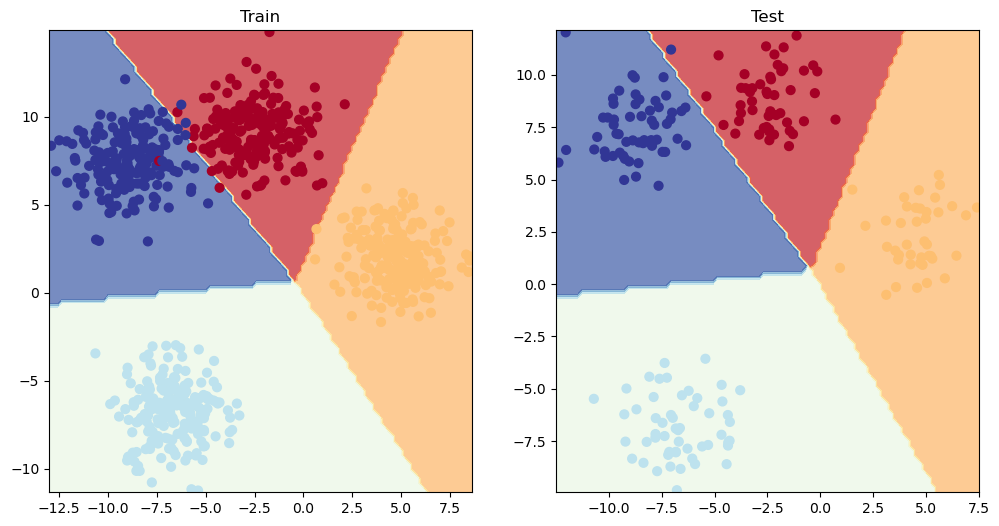

In [16]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

In [21]:
from torchmetrics import Accuracy
torchmetrics_accuracy = Accuracy(task="multiclass", num_classes=4).to(device)
torchmetrics_accuracy(y_preds, y_blob_test)


tensor(0.9950, device='mps:0')